In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup


driver = webdriver.Chrome('D:\sy\Project\ML\chromedriver.exe')
## 구글에 코로나 확진자 라는 키워드로 검색하는 url 작성
search_key = '코로나 확진자'
url = 'https://www.google.com/search?q={}'.format(search_key)

# 검색 키워드 url로 크롬드라이버를 이용하여 접속
driver.get(url)

#드라이버로 접속한 페이지의 소스를 읽어온다.
html = driver.page_source

#BeautifulSoup을 이용해서 html형식으로 파싱한다.
#아래의 soup을 출력하면 페이지의 모든 소스를 출력하게 된다.
soup = BeautifulSoup(html,'html.parser')

# 페이지의 소스중 ol 태그를 가진 모든 소스만 soup에 저장한다.
soup = soup.findAll("ol")

# ol태그만 파싱한 소스는 10개의 리스트로 이루어저 있다.
# print(len(soup)) 를 통해 알 수 있다.
# 그중 우리가 필요한 정보는 코로나 확진자 수와 날짜에 대한 정보이기 때문에 
# 그에 해당하는 2번째 리스트 soup[1] 을 선택하고 
# 이 정보는 <li></li>태그로 감싸저 있기 때문에 .text를 이용해서 텍스트 정보만 파싱한다.
all_count = soup[1].text

# 위의  all_count를 출력하면 일열로 쭉 ~~~ 늘어진 확진자 수와 날짜를 볼 수 있다.
# 조금더 깔끔하게 출력하고자 replace 함수를 사용하여 줄을 띄었다.
#print (all_count)
all_count = all_count.replace("일","일,").replace('1,','1').replace('회','').replace('월 ','-'). replace('일','')
all_count = all_count.strip()
all_count = all_count.split(",")
#print (all_count)


[ 4.09374250e+02  4.00198881e+02  3.91138138e+02  3.82191502e+02
  3.73358455e+02  3.64638480e+02  3.56031059e+02  3.47535674e+02
  3.39151807e+02  3.30878939e+02  3.22716554e+02  3.14664134e+02
  3.06721160e+02  2.98887115e+02  2.91161480e+02  2.83543738e+02
  2.76033372e+02  2.68629862e+02  2.61332692e+02  2.54141343e+02
  2.47055298e+02  2.40074039e+02  2.33197047e+02  2.26423806e+02
  2.19753796e+02  2.13186501e+02  2.06721402e+02  2.00357981e+02
  1.94095721e+02  1.87934104e+02  1.81872612e+02  1.75910727e+02
  1.70047931e+02  1.64283706e+02  1.58617534e+02  1.53048898e+02
  1.47577280e+02  1.42202161e+02  1.36923025e+02  1.31739352e+02
  1.26650626e+02  1.21656328e+02  1.16755940e+02  1.11948945e+02
  1.07234824e+02  1.02613061e+02  9.80831362e+01  9.36445326e+01
  8.92967323e+01  8.50392173e+01  8.08714698e+01  7.67929718e+01
  7.28032057e+01  6.89016533e+01  6.50877970e+01  6.13611188e+01
  5.77211009e+01  5.41672253e+01  5.06989743e+01  4.73158299e+01
  4.40172743e+01  4.08027

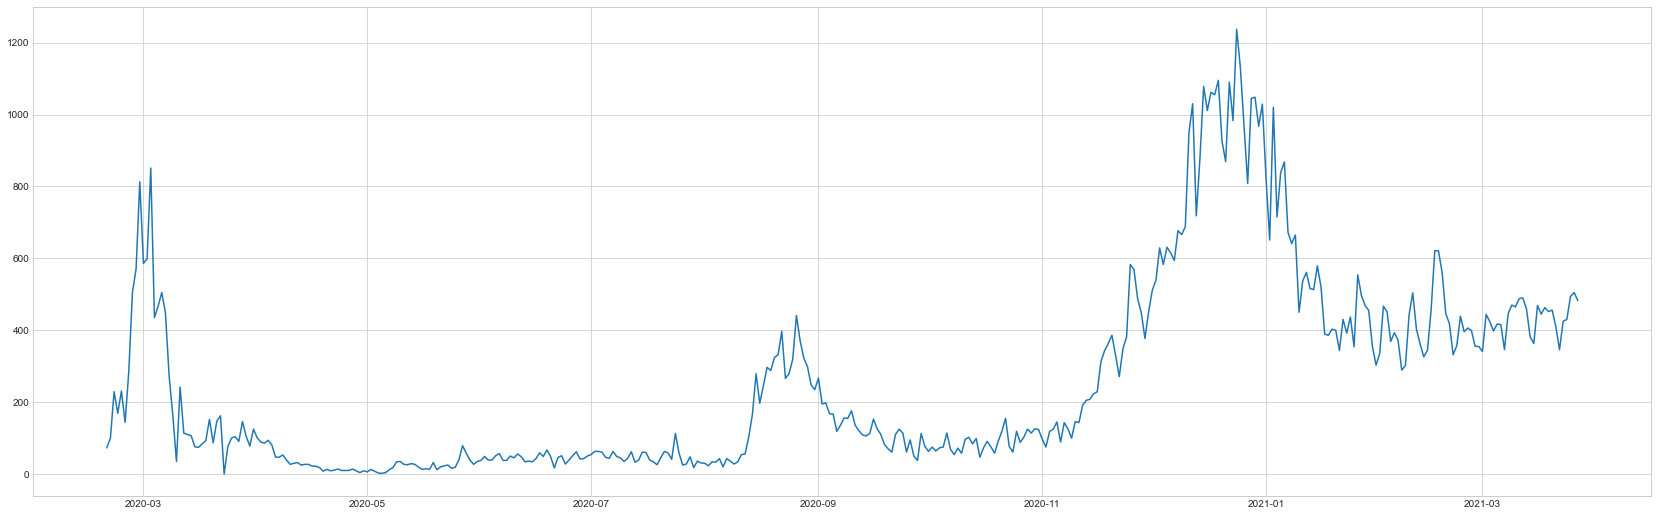

In [12]:
import pandas as pd
import numpy as np


count_list = []
small_list = []
year=2020
pre_month=''
for i , data in enumerate(all_count) :
    data = data.strip()
   # print(data, i)
    if i%2 == 1 and i !=0 :
        month,day = data.split('-')
        if (pre_month == '12' and month=='1'):
            year+=1
        data = pd.Timestamp(year,int(month),int(day))
        pre_month = month
    small_list.append(data)
    if i%2 == 1 and i !=0 :
        count_list.append(small_list)
        small_list = []

pdata = pd.DataFrame(count_list)
pdata.columns = ['count','date']


###### 데이터 저장
pdata.to_csv("daily_corona_conut.csv")


###### 데이터 시각화
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(29,9))

pdata['count'] = pd.to_numeric(pdata['count'])

# pdata['date'] = pd.Timestamp(2020,pdata['date'].split('-'))
plt.plot(pdata['date'],pdata['count'])

x=np.array(range(len(pdata['date'])))
y=np.array(pdata['count'])

z=np.polyfit(x,y,3)
p=np.poly1d(z)

k=np.array(range(len(pdata['date'])+100))
n=p(k)



In [58]:
pdata.describe()

pdata.groupby(pdata['date'].dt.strftime("%y-%m")).sum()

,count
date,
20-02,3119
20-03,6636
20-04,988
20-05,729
20-06,1347
20-07,1486
20-08,5846
20-09,3707
20-10,2746


In [5]:
from fbprophet import Prophet # version 0.6

# 데이터의 index를 초기화하고 컬럼명을 바꾼다.
count = pdata.reset_index(drop= True)
count = count.rename(columns={'date':'ds', 'count':'y'})
# Prophet() 모델을 읽어와서 
# fit로 학습한다.
print(count)
model = Prophet()
model.fit(count)

# freq 는 예측할 단위를 입력하면 됩니다. y,m,d (년,월,일) 
# periods 는 예측할 기간을 입력하면됩니다. 
future=model1.make_future_dataframe(periods=30, freq= 'd')
forecast_count = model1.predict(future)

#현황 및 예측 시각화
fig = model1.plot(forecast_count ,figsize=(10,5))

#경향성 분석 시각화
fig2 = model1.plot_components(forecast_count)


ModuleNotFoundError: No module named 'fbprophet'

In [8]:
import numpy as np
x=np.array(pdata['date'])
y=np.array(pdata['count'])

z=np.polyfit(x,y,3)
p=np.poly1d(z)

k=np.array(range(1,500))
n=p(k)
print(n)

NameError: name 'pdata' is not defined